## inspired from Coursera Deep Learning Specialization
#### We use faker for generating Fake Dates

In [0]:
!pip -q install faker
from faker import Faker
import numpy as np
import random
from babel.dates import format_date

In [0]:
faker = Faker()
faker.seed(5)
np.random.seed(5)

In [0]:
#these are the date formats we are going to generate
FORMATS = ['short','medium','medium','medium','long','long','long','long','long','full','full','full','d MMM YYY','d MMMM YYY',
           'd MMMM YYY','d MMMM YYY','d MMMM YYY','d MMMM YYY','dd/MM/YYY','EE d, MMM YYY','EEEE d, MMMM YYY','MMM d, YYY',
           'MMMM d, YYY','YYY, d MMM','YYY, d MMMM','EE YYY, d MMMM','EEEE YYY, d MM',]
for format in FORMATS:
    print('%s => %s' %(format, format_date(faker.date_object(), format=format, locale='en')))

short => 5/22/12
medium => May 21, 1987
medium => May 26, 1994
medium => Dec 26, 2016
long => May 16, 2014
long => January 26, 2006
long => December 22, 1971
long => September 8, 2001
long => December 13, 1986
full => Saturday, March 1, 2014
full => Thursday, July 12, 1973
full => Wednesday, September 3, 1980
d MMM YYY => 14 Sep 1977
d MMMM YYY => 20 April 1995
d MMMM YYY => 2 December 2001
d MMMM YYY => 12 October 1986
d MMMM YYY => 29 November 1995
d MMMM YYY => 2 January 2007
dd/MM/YYY => 09/12/1976
EE d, MMM YYY => Wed 21, Jan 2009
EEEE d, MMMM YYY => Saturday 20, December 1986
MMM d, YYY => Nov 22, 1970
MMMM d, YYY => September 30, 1984
YYY, d MMM => 1997, 10 Oct
YYY, d MMMM => 1989, 7 January
EE YYY, d MMMM => Sun 1982, 23 May
EEEE YYY, d MM => Tuesday 1996, 2 07


In [0]:
def random_date():
    dt = faker.date_between(start_date = '-500y',end_date='+50y')
    try:
        date = format_date(dt, format=random.choice(FORMATS), locale='en')
        human_readable = date.lower().replace(',', '')
        machine_readable = dt.isoformat()
    except AttributeError as e:
        return None, None, None
    return human_readable, machine_readable
random_date()

('8 december 1627', '1627-12-08')

In [0]:
human_vocab = set()
machine_vocab = set()
dataset = []
m = 50000
for i in range(m):
  hd,md = random_date()
  dataset.append((hd,md))
  human_vocab.update( tuple(hd) )
  machine_vocab.update( tuple(md) )
  
human_vocab.update(('<pad>','<unk>'))
human_vocab = dict(enumerate(human_vocab))
human_vocab = { v:i for i,v in human_vocab.items()  }

machine_vocab.add('<unk>')
machine_vocab = dict(enumerate(machine_vocab))
inv_machine_vocab = { v:i for i,v in machine_vocab.items()}

print(len(dataset),len(human_vocab),len(machine_vocab))
dataset[:10]

50000 36 12


[('14 october 2011', '2011-10-14'),
 ('14 october 1672', '1672-10-14'),
 ('15 january 1638', '1638-01-15'),
 ('1789 2 apr', '1789-04-02'),
 ('1774 12 apr', '1774-04-12'),
 ('08/01/1831', '1831-01-08'),
 ('saturday 1786 27 05', '1786-05-27'),
 ('monday 1683 31 05', '1683-05-31'),
 ('17 july 1749', '1749-07-17'),
 ('may 21 2049', '2049-05-21')]

In [0]:
#test set
t = 10000
testset= []
for i in range(t):
  hd,md = random_date()
  testset.append((hd,md))

In [0]:
HUMAN_VOCAB = len(human_vocab)
MACHINE_VOCAB = len(machine_vocab)
Tx = 30
Ty = 10
print( HUMAN_VOCAB, MACHINE_VOCAB )

36 12


##  Converting Human readable dates to character vectors
## Converting Machine Dates to character vectors

In [0]:
def string_to_ohe( string, T, vocab ):
  string = string.lower()
  arr = []
  while len(arr) < len(string):
    arr.append( vocab.get( string[len(arr)], vocab['<unk>']) )
    
  while len(arr) < T:
    arr.append( vocab['<pad>'] )
    
  onehot = np.zeros( (T,len(vocab)) )
  for i in range(T):
    onehot[ i, arr[i] ] = 1
  return onehot, arr

def output_to_date( out, vocab ):
  arr = np.argmax(out,axis=-1)
  string = ''
  for i in arr:
    string += vocab[ i ]
  return string

In [0]:
X = []
Y = []
for x,y in dataset:
  X.append( string_to_ohe(x, Tx, human_vocab)[0] )
  Y.append( string_to_ohe(y, Ty, inv_machine_vocab)[0] )
X,Y = np.array(X), np.array(Y)
X.shape, Y.shape

((50000, 30, 36), (50000, 10, 12))

In [0]:
Xt, Yt = [],[]
for x,y in testset:
  Xt.append( string_to_ohe(x, Tx, human_vocab)[0] )
  Yt.append( string_to_ohe(y, Ty, inv_machine_vocab)[0] )
Xt,Yt = np.array(Xt), np.array(Yt)
Xt.shape, Yt.shape

((10000, 30, 36), (10000, 10, 12))

## Attention Model

| Overall | Attention Mechanism |
|-------------|------------------------|
| ![alt text](https://github.com/adityajn105/Coursera-Deep-Learning-Specialization/raw/26cf7da29b2f1cb32799e045cc9cdfab99ad0757/4.%20Sequence%20Models/Week%203/Machine%20Translation/images/attn_model.png) | ![alt text](https://raw.githubusercontent.com/adityajn105/Coursera-Deep-Learning-Specialization/26cf7da29b2f1cb32799e045cc9cdfab99ad0757/4.%20Sequence%20Models/Week%203/Machine%20Translation/images/attn_mechanism.png) |

* The post-attention LSTM passes $s^{\langle t \rangle}, c^{\langle t \rangle}$ from one time step to the next.
* in this model the post-attention LSTM at time $t$ does will not take the specific generated $y^{\langle t-1 \rangle}$ as input; it only takes $s^{\langle t\rangle}$ and $c^{\langle t\rangle}$ as input. 
* We use $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}; \overleftarrow{a}^{\langle t \rangle}]$ to represent the concatenation of the activations of both the forward-direction and backward-directions of the pre-attention Bi-LSTM.
* The diagram on the right uses a RepeatVector node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times, and then Concatenation to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ to compute $e^{\langle t, t'}$, which is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$. We'll explain how to use RepeatVector and Concatenation in Keras below.



In [0]:
from keras.layers import RepeatVector, Concatenate, Dense, Dot, Activation
#combines activations generated from BiLSTM with previous state of Post LSTM cell to get attention to be given to each timestep
#heart of attention model
def one_step_attention( a, s_prev ):
  x = RepeatVector(Tx)(s_prev)             #repeat s_prev Tx times
  x = Concatenate(axis=-1)( [ a, x ] )     #concat each copy of s_prev with each timestep hidden state
  e = Dense(10, activation='tanh')(x)      #pass each concatenated vector through Dense Layer to get intermediate energies
  energy = Dense(1, activation='relu')(e)  #get timestep's energy 
  alphas = Activation('softmax')(energy)   #convert energy to probabilities i.e. attention weights
  context = Dot(axes=1)([alphas,a])        #multiply attention weights and timestep hidden state to get context vector
  return context

In [0]:
from keras.layers import Input, Bidirectional, LSTM
from keras.models import Model

n_a = 32 #pre attention LSTM state, since Bi directional attention=64
n_s = 64 #post attention LSTM state

inp = Input( (Tx, HUMAN_VOCAB ) )
s0 = Input( (n_s,) )
c0 = Input( (n_s,) )

outputs = []

s=s0
c=c0
a = Bidirectional( LSTM( n_a, return_sequences=True ) )(inp) #generate hidden state for every timestep

"https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/"
postLSTM = LSTM( n_s, return_state = True)

output = Dense( MACHINE_VOCAB, activation='softmax') #our final output layer

for _ in range(Ty): #iterate for every output step
  context = one_step_attention(a, s) #get context
  s,_,c = postLSTM(context, initial_state=[s,c]) #generate cell_state_seq(currently 1), cell_state, memory  
  out = output(s)
  outputs.append(out)
  
model = Model( [inp,s0,c0], outputs )

In [0]:
from keras.optimizers import Adam
model.compile( optimizer=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01), loss='categorical_crossentropy', metrics=['accuracy'] )

s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))

Y = list(Y.swapaxes(0,1))
Yt = list(Yt.swapaxes(0,1))

history = model.fit( [X,s0,c0], Y, epochs=100, 
                    validation_data=([Xt,np.zeros((t, n_s)),np.zeros((t, n_s))],Yt), 
                    batch_size=128, verbose=1)
model.save_weights('model_weights.h5')

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 78s 2ms/step - loss: 11.2930 - dense_22_loss: 1.9524 - dense_22_acc: 0.9110 - dense_22_acc_1: 0.5205 - dense_22_acc_2: 0.3751 - dense_22_acc_3: 0.3464 - dense_22_acc_4: 0.9391 - dense_22_acc_5: 0.7102 - dense_22_acc_6: 0.4292 - dense_22_acc_7: 0.8778 - dense_22_acc_8: 0.4971 - dense_22_acc_9: 0.2729 - val_loss: 6.9230 - val_dense_22_loss: 1.5244 - val_dense_22_acc: 0.9458 - val_dense_22_acc_1: 0.6220 - val_dense_22_acc_2: 0.4553 - val_dense_22_acc_3: 0.4309 - val_dense_22_acc_4: 0.9992 - val_dense_22_acc_5: 0.9759 - val_dense_22_acc_6: 0.8128 - val_dense_22_acc_7: 0.9993 - val_dense_22_acc_8: 0.7171 - val_dense_22_acc_9: 0.4053
Epoch 2/100
50000/50000 [==============================] - 64s 1ms/step - loss: 5.9541 - dense_22_loss: 1.3018 - dense_22_acc: 0.

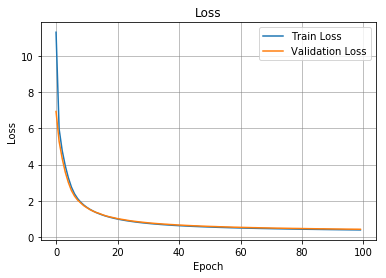

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
epoch_list = history.epoch
plt.plot(epoch_list, history.history['loss'], label='Train Loss')
plt.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss');plt.xlabel('Epoch');plt.title('Loss')
plt.legend(loc="best");plt.grid(color='gray', linestyle='-', linewidth=0.5)

In [0]:
model.load_weights('model.h5')
def getTranslation(date,model):
  date = date.lower().replace(',','')
  source = np.array(string_to_ohe(date, Tx, human_vocab)[0])
  source = np.expand_dims(source,axis=0)
  prediction = np.array(model.predict([source, s0, c0]))
  prediction = np.squeeze(prediction.swapaxes(0,1))
  return output_to_date(prediction,machine_vocab)

EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', 
            '1 March 2001','jun 10 2017','11/07/2002']

for example in EXAMPLES:
    print(f"{example} -> {getTranslation(example,model)}")

3 May 1979 -> 1979-05-03
5 April 09 -> 2019-05-00
21th of August 2016 -> 2016-08-21
Tue 10 Jul 2007 -> 2007-07-10
Saturday May 9 2018 -> 2018-05-09
March 3 2001 -> 2001-03-03
March 3rd 2001 -> 2001-03-03
1 March 2001 -> 2001-03-01
jun 10 2017 -> 2017-06-10
11/07/2002 -> 2002-00-17


In [0]:
done = False
while not done:
  dt = input("Enter Date : ")
  print(f"Translation : {getTranslation(dt,model)}     Continue('y/n') :",end="")
  done = input() == 'n'

Enter Date : 10th of march 1789
Translation : 1789-03-10     Continue('y/n') :y
Enter Date : thursday, may 10 1996
Translation : 1996-05-10     Continue('y/n') :y
Enter Date : august 17 2004
Translation : 2004-08-17     Continue('y/n') :n


## Here's what you should remember

- Machine translation models can be used to map from one sequence to another. They are useful not just for translating human languages (like French->English) but also for tasks like date format translation. 
- An attention mechanism allows a network to focus on the most relevant parts of the input when producing a specific part of the output. 
- A network using an attention mechanism can translate from inputs of length $T_x$ to outputs of length $T_y$, where $T_x$ and $T_y$ can be different. 
- You can visualize attention weights $\alpha^{\langle t,t' \rangle}$ to see what the network is paying attention to while generating each output.
- Attention model is used to learn complex mappings from one sequence to another.